# Hydrological mass-balance output

**New in version 1.4.1!** (unreleased)

In two recent PRs ([GH1224](https://github.com/OGGM/oggm/pull/1224), [GH1232](https://github.com/OGGM/oggm/pull/1232) and [GH1242](https://github.com/OGGM/oggm/pull/1242)), we have added a new task in OGGM, `run_with_hydro`, which adds mass-balance and runoff diagnostics to the OGGM output files.

This task is still experimental - it is tested for consistency and mass-conservation and we trust its output, but its API and functionalites might change in the future (in particular to make it faster and to add more functionality, as explained below).

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Make pretty plots
sns.set_style('ticks')
sns.set_context('notebook')

In [3]:
from oggm import cfg, utils, workflow, tasks, graphics
from oggm_edu import read_run_results, compute_climate_statistics

In [4]:
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGMHydro')

2021-05-04 13:33:36: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-05-04 13:33:36: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-05-04 13:33:36: oggm.cfg: Multiprocessing: using all available processors (N=8)


### Define the glacier we will play with

For this notebook we use the Hintereisferner, Austria. Some other possibilities to play with:

- Shallap Glacier: RGI60-16.02207
- Artesonraju: RGI60-16.02444 ([reference glacier](https://cluster.klima.uni-bremen.de/~github/crossval/1.1.2.dev45+g792ae9c/web/RGI60-16.02444.html))
- Hintereisferner: RGI60-11.00897 ([reference glacier](https://cluster.klima.uni-bremen.de/~github/crossval/1.1.2.dev45+g792ae9c/web/RGI60-11.00897.html))

And virtually any glacier you can find the RGI Id from, e.g. in the [GLIMS viewer](https://www.glims.org/maps/glims).

In [5]:
# Hintereisferner
rgi_id = 'RGI60-11.00897'

## Preparing the glacier data

This can take up to a few minutes on the first call because of the download of the required data:

In [6]:
# We pick the elevation-bands glaciers because they run a bit faster
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match'
gdir = workflow.init_glacier_directories([rgi_id], from_prepro_level=5, prepro_border=80, prepro_base_url=base_url)[0]

2021-05-04 13:33:37: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2021-05-04 13:33:37: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


## "Commitment run" 

This runs a simulation for 100 yrs under a constant climate based on the climate of the last 11 years:

In [7]:
# file identifier where the model output is saved
file_id = '_ct'
tasks.run_with_hydro(gdir, run_task=tasks.run_constant_climate, nyears=100, y0=2014, halfsize=5, store_monthly_hydro=True, 
                     output_filesuffix=file_id);

Let's have a look at the output:

In [8]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

There are plenty of new variables in this dataset! We can list them with:

In [9]:
ds

<xarray.Dataset>
Dimensions:                       (month_2d: 12, time: 100)
Coordinates:
  * time                          (time) float64 0.0 1.0 2.0 ... 97.0 98.0 99.0
    hydro_year                    (time) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
    hydro_month                   (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    calendar_year                 (time) int64 -1 0 1 2 3 4 ... 94 95 96 97 98
    calendar_month                (time) int64 10 10 10 10 10 ... 10 10 10 10 10
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 10 11 12 1 2 3 4 5 6 7 8 9
Data variables: (12/26)
    volume_m3                     (time) float64 6.305e+08 ... 8.315e+07
    volume_bsl_m3                 (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl_m3                 (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area_m2                       (time) float64 8.036e+06 ... 2.501e+06
    length_m                      (time) float64 5.6e+03 5.7e+03 ... 1.1e+03
    calving_m3                    (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                            ...
    snowfall_on_glacier_monthly   (time, month_2d) float64 1.969e+09 ... 4.89...
    snow_bucket                   (time) float64 0.0 0.0 ... 9.693e+08 9.796e+08
    snow_bucket_monthly           (time, month_2d) float64 0.0 ... 9.891e+08
    model_mb                      (time) float64 -1.578e+10 ... -2.228e+07
    residual_mb                   (time) float64 4.279e+07 ... -5.636e+06
    residual_mb_monthly           (time, month_2d) float64 1.128e+06 ... -6.0...
Attributes:
    description:          OGGM model output
    oggm_version:         1.4.1.dev19+gd4170e8
    calendar:             365-day no leap
    creation_date:        2021-05-04 11:33:37
    water_level:          0
    glen_a:               6.774049426121393e-24
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance
    mb_model_hemisphere:  nh

### Annual runoff 

The annual variables are stored as usual with the time dimension. For example:

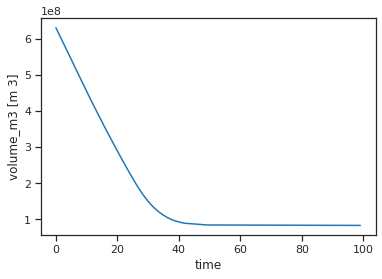

In [10]:
ds.volume_m3.plot();

The new hydrological variables are also available. Let's make a pandas DataFrame of all "1D" (annual) variables:

In [11]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

The hydrological variables are computed on the largest possible area that was covered by glacier ice in the simulation. This is equivalent to the runoff that would be measured at a fixed-gauge station at the glacier terminus. The total annual runoff is:

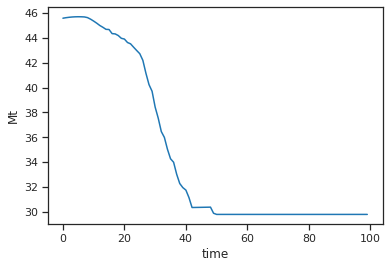

In [12]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9
df_runoff.sum(axis=1).plot(); plt.ylabel('Mt');

It consists of the following components:
- melt off-glacier: snow melt on areas that are now glacier free (i.e. 0 in the year of largest glacier extent, in this example at the start of the simulation)
- melt on-glacier: ice + seasonal snow melt on the glacier
- liquid precipitaton on- and off-glacier (the latter being zero at the year of largest glacial extent, in this example at start of the simulation)

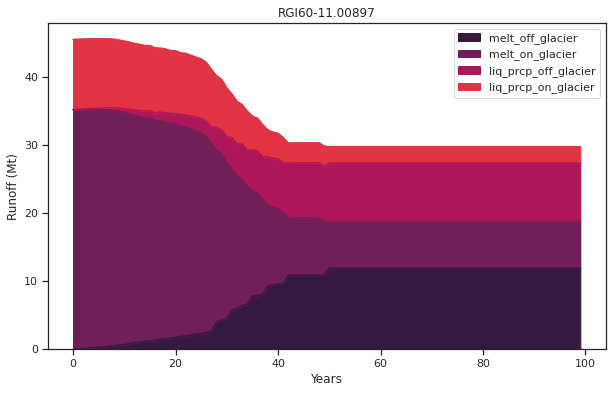

In [13]:
f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

As the glacier retreats, total runoff decreases as a result of the decreasing glacier contribution.

### Monthly runoff 

The "2D" variables contain the same data but at monthly resolution, with the dimension (time, month). For example, runoff can be computed the 
same way:

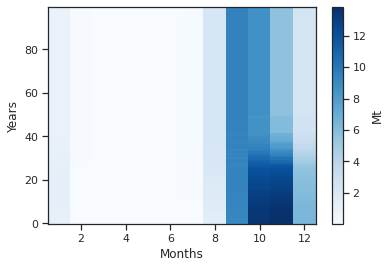

In [14]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly'] + ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly'] 
monthly_runoff *= 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label':'Mt'}); plt.xlabel('Months'); plt.ylabel('Years');

Something is a bit wrong: the coordinates are hydrological months - let's make this better:

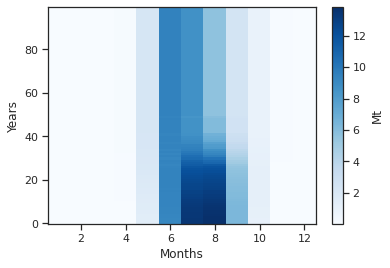

In [15]:
# This should work in both hemispheres maybe?
ds_roll = ds.roll(month_2d=ds['calendar_month_2d'].data[0]-1, roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds_roll['melt_off_glacier_monthly'] + ds_roll['melt_on_glacier_monthly'] + ds_roll['liq_prcp_off_glacier_monthly'] + ds_roll['liq_prcp_on_glacier_monthly'] 
monthly_runoff *= 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label':'Mt'}); plt.xlabel('Months'); plt.ylabel('Years');

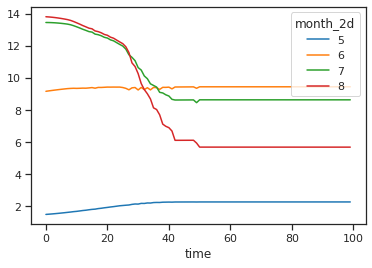

In [16]:
monthly_runoff.sel(month_2d=[5, 6, 7, 8]).plot(hue='month_2d');

The runoff is approx. zero in the winter months, and is high in summer. The annual cycle changes as the glacier retreats: 

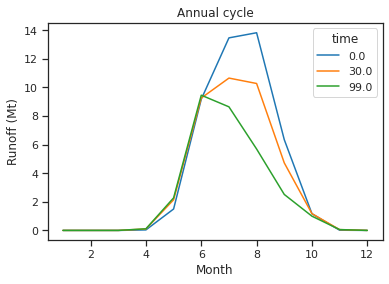

In [17]:
monthly_runoff.sel(time=[0, 30, 99]).plot(hue='time'); plt.title('Annual cycle'); plt.xlabel('Month'); plt.ylabel('Runoff (Mt)');

Let's distinguish between the various components of the monthly runnoff for two 10 years periods (begining and end of the 100 year simulation): 

In [18]:
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'month_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_m_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)

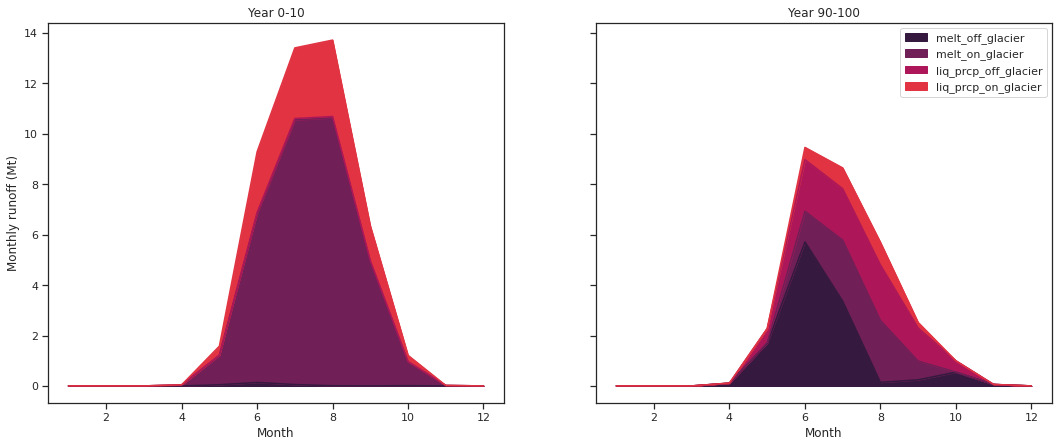

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

## Random climate commitment run 

Same as before, but this time randomly shuffling each year of the last 11 years:

In [20]:
# file identifier where the model output is saved
file_id = '_rd'
tasks.run_with_hydro(gdir, run_task=tasks.run_random_climate, nyears=100, y0=2014, halfsize=5, store_monthly_hydro=True,
                     seed=0, unique_samples=True,
                     output_filesuffix=file_id);

In [21]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

### Annual runoff 

In [22]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

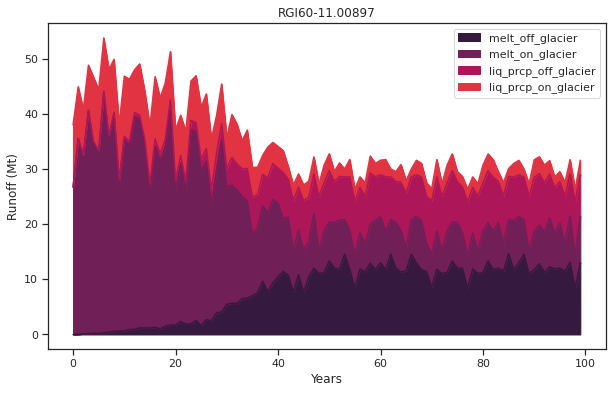

In [23]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

### Monthly runoff 

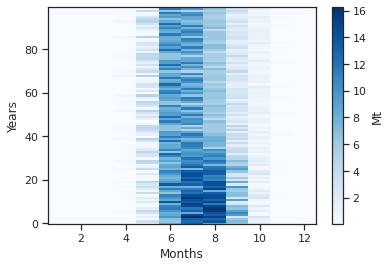

In [24]:
ds_roll = ds.roll(month_2d=ds['calendar_month_2d'].data[0]-1, roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds_roll['melt_off_glacier_monthly'] + ds_roll['melt_on_glacier_monthly'] + ds_roll['liq_prcp_off_glacier_monthly'] + ds_roll['liq_prcp_on_glacier_monthly'] 
monthly_runoff *= 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label':'Mt'}); plt.xlabel('Months'); plt.ylabel('Years');

In [25]:
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'month_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_m_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)

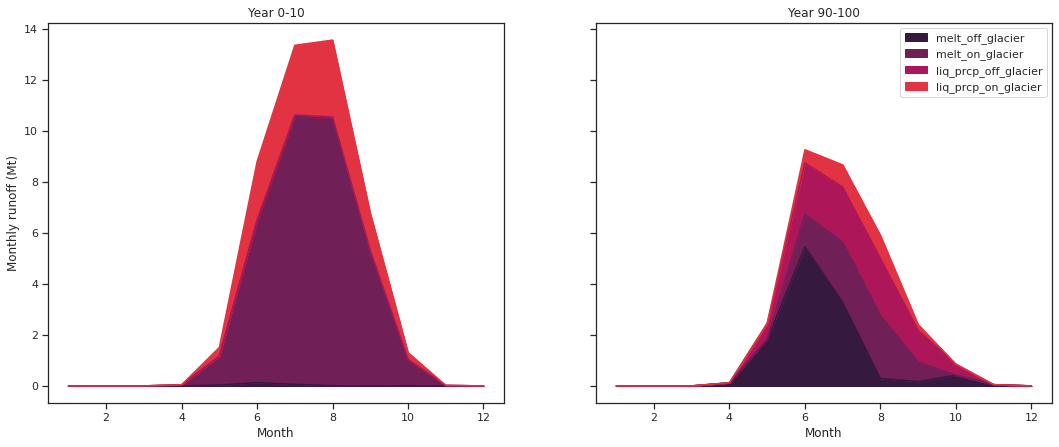

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

## CMIP5 projection run 

This time, let's start from the estimated glacier state in 2020 and run a projection from there. See the [run_with_gcm](run_with_gcm.ipynb) tutorial.

In [27]:
# "Downscale" the climate data
from oggm.shop import gcm_climate
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip_data, [gdir],
                                 filesuffix='_CCSM4_{}'.format(rcp),  # recognize the climate file for later
                                 fpath_temp=ft,  # temperature projections
                                 fpath_precip=fp,  # precip projections
                                 );

2021-05-04 13:33:43: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-05-04 13:33:47: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-05-04 13:33:49: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-05-04 13:33:51: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers


In [28]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data, ys=2020,
                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                         climate_input_filesuffix=rid,  # use the chosen scenario
                         init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                         output_filesuffix=rid,  # recognize the run for later
                         store_monthly_hydro=True,  # add monthly diagnostics
                        );

## RCP2.6

In [29]:
file_id = '_CCSM4_rcp26'

In [30]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

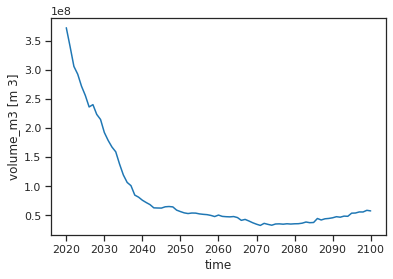

In [31]:
ds.volume_m3.plot();

### Annual runoff 

In [32]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

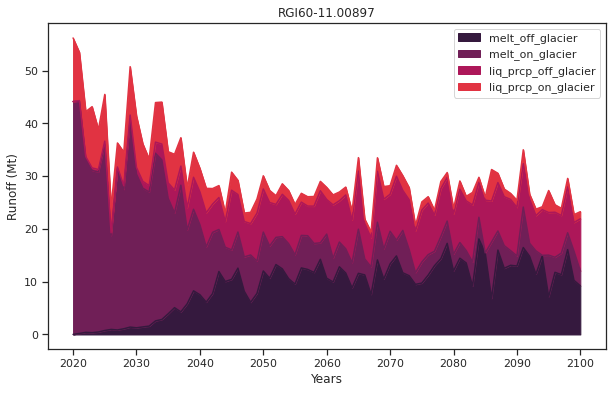

In [33]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars].clip(0) * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

### Monthly runoff 

In [34]:
ds_roll = ds.roll(month_2d=ds['calendar_month_2d'].data[0]-1, roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

In [35]:
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'month_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_m_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)

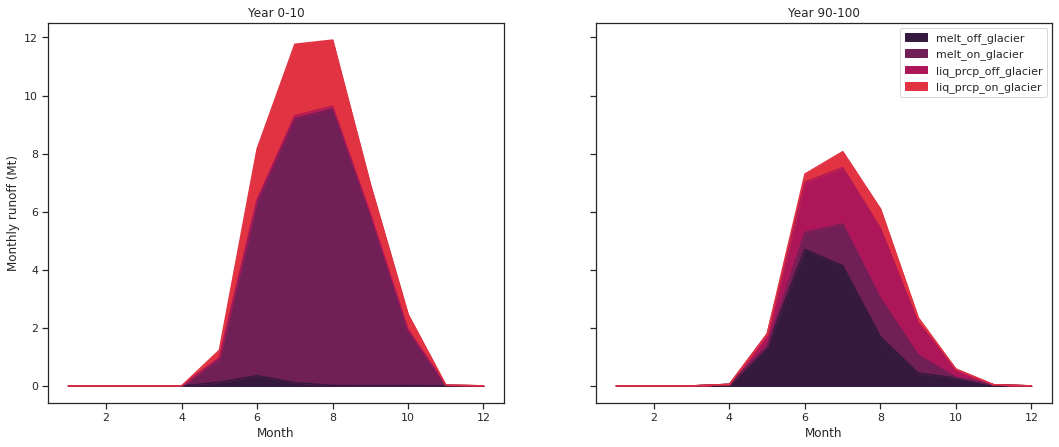

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

## RCP8.5 

In [37]:
file_id = '_CCSM4_rcp85'

In [38]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

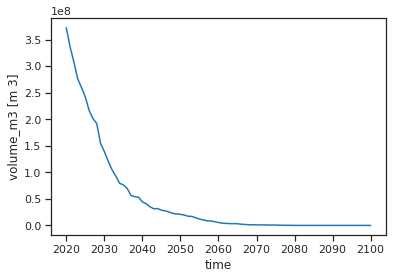

In [39]:
ds.volume_m3.plot();

### Annual runoff 

In [40]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

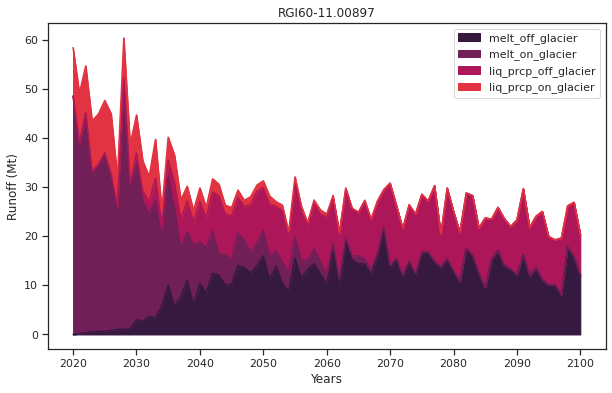

In [41]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

### Monthly runoff 

In [42]:
ds_roll = ds.roll(month_2d=ds['calendar_month_2d'].data[0]-1, roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

In [43]:
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'month_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_m_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)

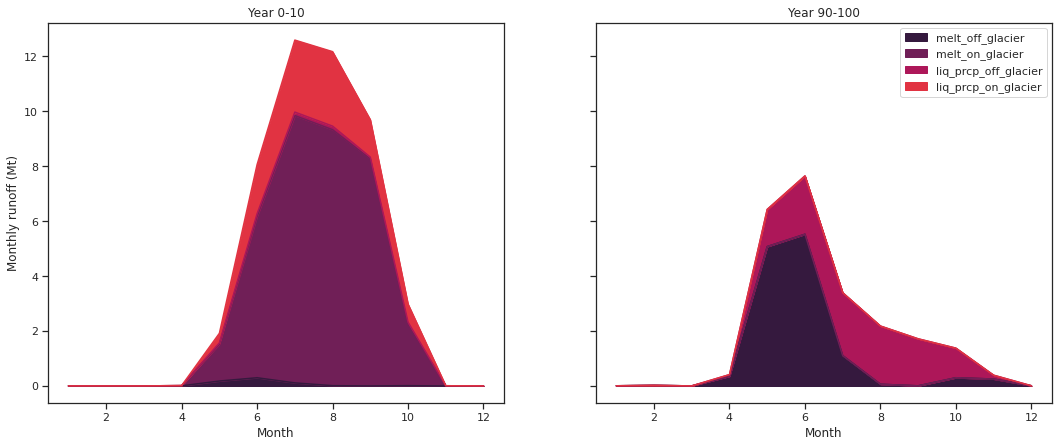

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

## Calculating peak water under different climate scenarios

A typical usecase for simulating and analysing the hydrological ouptuts of glaciers are for **peak water** estimations. For instance, we might want to know the point in time when the annual total runoff from a glacier reaches its maximum under a certain climate scenario. 

The total runoff is a sum of the melt and liquid precipitation, from both on and off the glacier. **Peak water** can be calculated from the 11-year moving average of the total runoff ([Huss and Hock, 2018](http://www.nature.com/articles/s41558-017-0049-x)).

For Hintereisferner we have alredy run the simulations for the different climate scenarios, so we can sum up the runoff variables and plot the output.

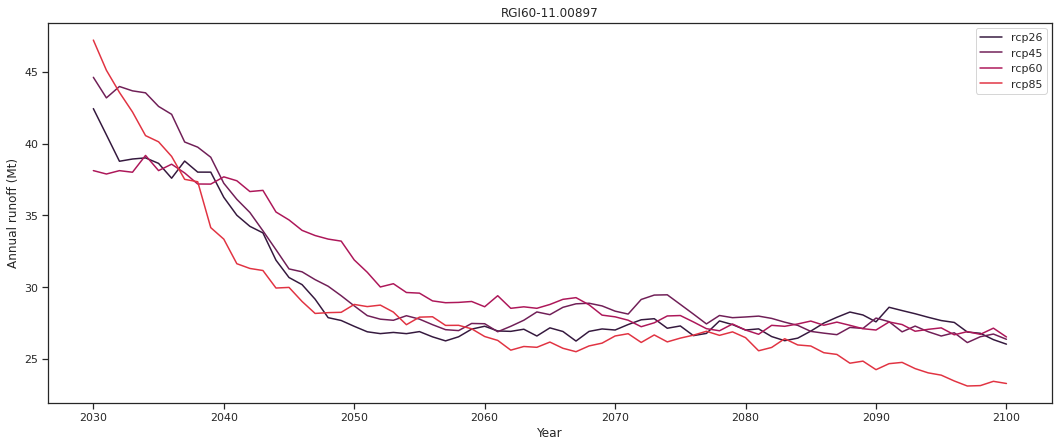

In [45]:
# Create the figure
f, ax = plt.subplots(figsize=(18, 7), sharex=True)
# Loop all scenarios
for i, rcp in enumerate(['rcp26', 'rcp45', 'rcp60', 'rcp85']):
    file_id = f'_CCSM4_{rcp}'
    # Open the corresponding data.
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                           filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier',
                   'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean
    # and plot it.
    df_runoff.sum(axis=1).rolling(window=11).mean().plot(ax=ax, label=rcp,
                               color=sns.color_palette("rocket")[i],
                               )
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title(rgi_id)
plt.legend();


For Hintereisferner, runoff continues to decrease throughout the 21st-century for all scenarios, indicating that **peak water** has already been reached sometime in the past. This is the case for many European glaciers. Let us take a look at another glacier, in a different climatical setting where a different hydrological projection can be expected.

We pick a glacier (RGI60-15.02420, unnamed) in the Eastern Himalayas. First we need to initialize its glacier directory.

In [46]:
# Unnamed glacier
rgi_id = 'RGI60-15.02420'

In [47]:
gdir = workflow.init_glacier_directories([rgi_id], from_prepro_level=5, prepro_border=80, prepro_base_url=base_url)[0]

2021-05-04 13:33:59: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2021-05-04 13:33:59: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


Then, we have to process the climate data for the new glacier.

In [48]:
# Do we need to download data again? I guess it is stored somewhere,
# but this is an easy way to loop over it for bias correction.
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    workflow.execute_entity_task(gcm_climate.process_cmip_data, [gdir],
                                 # Name file to recognize it later
                                 filesuffix='_CCSM4_{}'.format(rcp),  
                                 # temperature projections
                                 fpath_temp=ft,  
                                 # precip projections
                                 fpath_precip=fp,  
                                 );

2021-05-04 13:34:00: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-05-04 13:34:02: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-05-04 13:34:03: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-05-04 13:34:05: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers


With this done, we can run the simulations for the different climate scenarios.

In [49]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data, ys=2020,
                         # use gcm_data, not climate_historical
                         climate_filename='gcm_data',
                         # use the chosen scenario
                         climate_input_filesuffix=rid,
                         # this is important! Start from 2020 glacier
                         init_model_filesuffix='_historical',
                         # recognize the run for later
                         output_filesuffix=rid,
                         # add monthly diagnostics
                         store_monthly_hydro=True,
                        );

Now we can create the same plot as before in order to visualize **peak water**

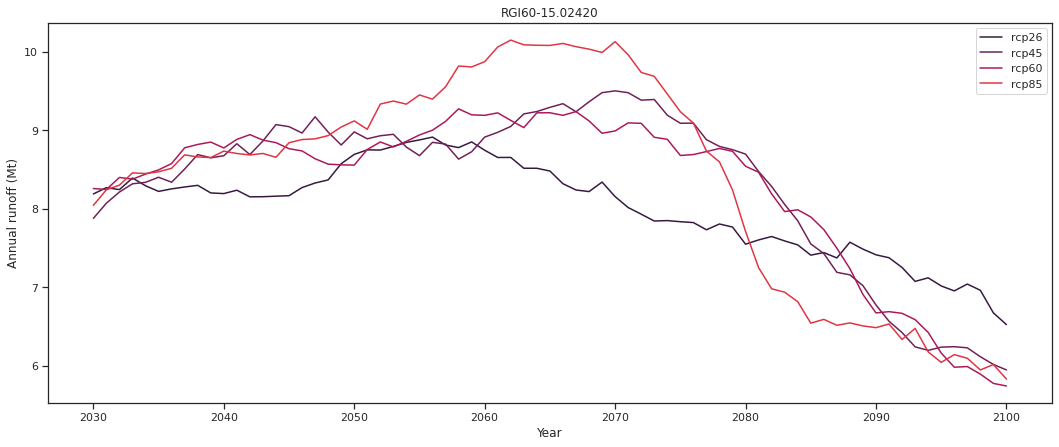

In [50]:
# Create the figure
f, ax = plt.subplots(figsize=(18, 7))
# Loop all scenarios
for i, rcp in enumerate(['rcp26', 'rcp45', 'rcp60', 'rcp85']):
    file_id = f'_CCSM4_{rcp}'
    # Open the corresponding data in a context manager.
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                           filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier',
                   'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean
    # and plot it.
    df_runoff.sum(axis=1).rolling(window=11).mean().plot(ax=ax, label=rcp,
                               color=sns.color_palette("rocket")[i]
                              )
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title(rgi_id)
plt.legend();


Unlike for Hintereisferner, these projections indicate that the annual runoff will increase in all the scenarios for the first half of the century. The higher RCP scenarios can reach **peak water** later in the century, since the excess melt can continue to increase. For the lower RCP scenarios on the other hand, the glacier might be approaching a new equilibirum, which reduces the runoff earlier in the century ([Rounce et. al., 2020](https://www.frontiersin.org/articles/10.3389/feart.2019.00331/full)). After **peak water** is reached (RCP2.6: ~2055, RCP8.5: ~2070 in these projections), the annual runoff begin to decrease. This decrease occurs because the shrinking glacier is no longer able to support the high levels of melt.